Prophet Modeling

-  Prophet is capable of handling missing data points and outliers, making it a robust tool for forecasting real-world data
- single regressor model typically refers to a model where you have only one predictor variable (regressor) to forecast the target variable (usually a time series)
- In the case of Prophet, the single regressor model means you have one additional input feature (regressor) to aid in forecasting the target time series data
- Prophet allows you to include additional regressor variables to improve the accuracy of your forecasts. These regressors can represent any relevant information that might impact the time series you are trying to predict. For example, if you are forecasting daily sales data, a regressor could be a binary variable indicating whether it's a holiday or not. Including such additional information can help Prophet make more accurate predictions.

- Additive Regressive Model
- y(t) = g(t) (trend factor) + h(t) (holiday component) + s(t) (seasonality component) + e

- Trend factor: logistic growth model or piecewise linear model

In [1]:
import pandas as pd
from prophet import Prophet
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

In [2]:
# import data
df = pd.read_csv('df_post_eda.csv')
df.head()

,Date,MMWR_week,Location,Distributed,Distributed_Janssen,Distributed_Moderna,Distributed_Pfizer,Distributed_Unk_Manuf,Dist_Per_100K,Distributed_Per_100k_5Plus,...,day_of_week,quarter,dayofyear,dayofmonth,weekofyear,season,holidays,holiday_season,vax_announcement,Additional_Doses_Vax_Pct_1_w_lag
0,2023-05-10,19,NE,5481710,152400,1647380,2905630,0,283379,303944.0,...,Wednesday,2,130,10,19,spring,Normal day,False,False,NaN
1,2023-05-10,19,LA,10282120,330500,3807980,5164550,0,221178,236516.0,...,Wednesday,2,130,10,19,spring,Normal day,False,False,55.8
2,2023-05-10,19,GA,28727475,869100,9763000,14773655,0,270569,288404.0,...,Wednesday,2,130,10,19,spring,Normal day,False,False,43.3
3,2023-05-10,19,WY,1281755,49300,490040,585605,0,221466,235691.0,...,Wednesday,2,130,10,19,spring,Normal day,False,False,44.3
4,2023-05-10,19,CO,17769135,501900,5402640,9029715,0,308560,327449.0,...,Wednesday,2,130,10,19,spring,Normal day,False,False,47.3


In [3]:
# Predictive variable
pred_var = 'Additional_Doses_Vax_Pct'

In [4]:
# Date column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date')[pred_var].mean()

In [6]:
df = pd.DataFrame(df)
df.reset_index(level=0, inplace=True)
df = df.rename(columns={'Date': 'ds', 'Additional_Doses_Vax_Pct': 'y'})
df.tail()

,ds,y
75,2023-04-12,50.951563
76,2023-04-19,51.012500
77,2023-04-26,51.034375
78,2023-05-03,51.064062
79,2023-05-10,51.076563


In [7]:
df.head()

,ds,y
0,2021-11-03,10.332812
1,2021-11-10,13.185937
2,2021-11-17,15.871875
3,2021-11-24,18.675000
4,2021-12-01,20.689062


## Initial Prophet

In [8]:
# Instantiating a new Prophet model
# Assuming linear regression
m = Prophet()
m.fit(df)

19:09:32 - cmdstanpy - INFO - Chain [1] start processing
19:09:32 - cmdstanpy - INFO - Chain [1] done processing


In [9]:
# Extend DF into future - Weekly on wednesdays
future = m.make_future_dataframe(periods=52, freq='W-WED')
future.tail()

,ds
127,2024-04-10
128,2024-04-17
129,2024-04-24
130,2024-05-01
131,2024-05-08


In [10]:
# Assign future values a predicted value
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
127,2024-04-10,52.786855,32.977865,74.915352
128,2024-04-17,52.821918,32.164208,75.510635
129,2024-04-24,52.856981,31.696203,76.351682
130,2024-05-01,52.892044,30.967136,76.902874
131,2024-05-08,52.927107,30.344034,77.661878


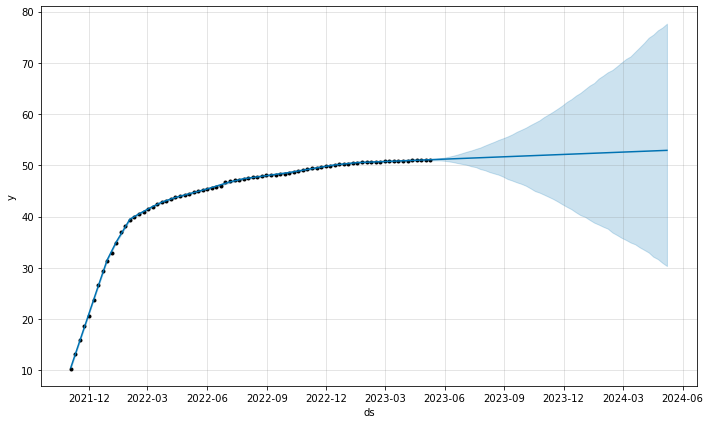

In [11]:
# Plot forecast
fig1 = m.plot(forecast)

## Max Capacity - Logistic Growth

In [12]:
# Need to set max capacity because of logistic regression
# set as 53 for now

df['cap'] = 53

In [13]:
m = Prophet(growth='logistic')
m.fit(df)

19:09:33 - cmdstanpy - INFO - Chain [1] start processing
19:09:33 - cmdstanpy - INFO - Chain [1] done processing


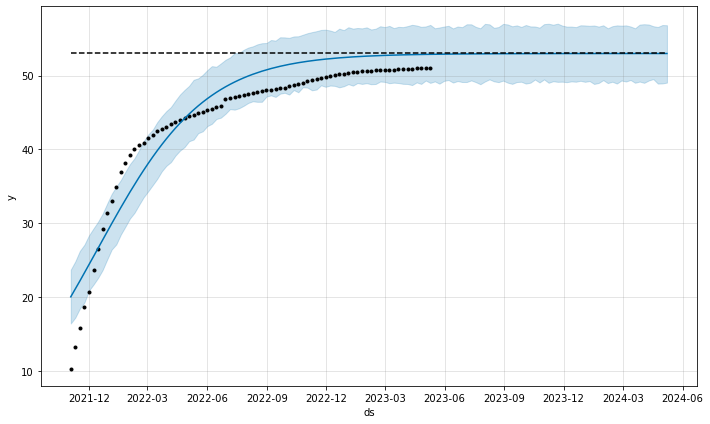

In [14]:
future = m.make_future_dataframe(periods=52, freq='W-WED')
future['cap'] = 53
fcst = m.predict(future)
fig = m.plot(fcst)

In [15]:
fcst.tail()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
127,2024-04-10,52.998082,53,49.344346,56.924890,52.998082,52.998082,0.0,0.0,0.0,0.0,0.0,0.0,52.998082
128,2024-04-17,52.998238,53,49.536241,56.697151,52.998238,52.998238,0.0,0.0,0.0,0.0,0.0,0.0,52.998238
129,2024-04-24,52.998380,53,48.925376,56.589987,52.998380,52.998380,0.0,0.0,0.0,0.0,0.0,0.0,52.998380
130,2024-05-01,52.998512,53,48.941932,56.855190,52.998512,52.998512,0.0,0.0,0.0,0.0,0.0,0.0,52.998512
131,2024-05-08,52.998632,53,49.058595,56.828107,52.998632,52.998632,0.0,0.0,0.0,0.0,0.0,0.0,52.998632


In [16]:
# Initial RMSE

# Extract actual values and predicted values
actual_values = df['y']
predicted_values = fcst['yhat'][:-52] 

In [17]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 2.9593725179628465


In [18]:
mean_absolute_error(actual_values,
                   predicted_values)

2.555044788524841

## Change Points

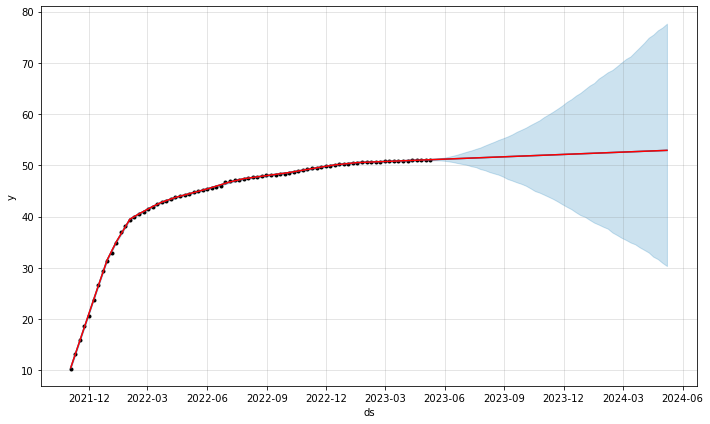

In [19]:
from prophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [20]:
# Change points doesn't apply - logistic regression

## Adding Country Holidays

In [21]:
df.drop('cap', axis=1, inplace=True)

In [22]:
# Python
m_Holiday = Prophet()
m_Holiday.add_country_holidays(country_name='US')
m_Holiday.fit(df)

19:09:33 - cmdstanpy - INFO - Chain [1] start processing
19:09:34 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
m_Holiday.train_holiday_names

0                          Martin Luther King Jr. Day
1                               Washington's Birthday
2                                        Columbus Day
3                                      New Year's Day
4                           New Year's Day (Observed)
5                                        Memorial Day
6                Juneteenth National Independence Day
7     Juneteenth National Independence Day (Observed)
8                                    Independence Day
9                         Independence Day (Observed)
10                                          Labor Day
11                                       Veterans Day
12                                       Thanksgiving
13                                      Christmas Day
14                           Christmas Day (Observed)
15                            Veterans Day (Observed)
dtype: object

In [24]:
future = m_Holiday.make_future_dataframe(periods=52, freq='W-WED')

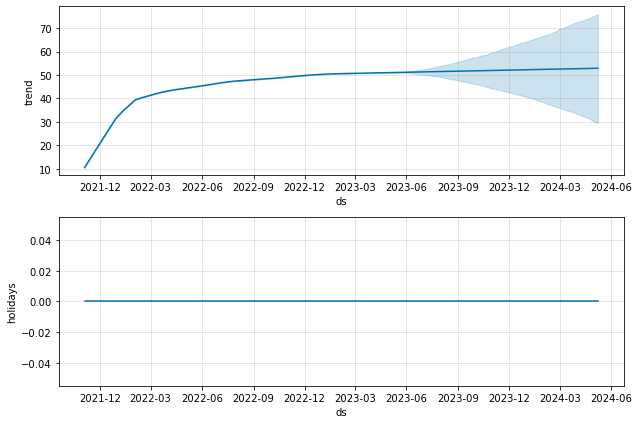

In [25]:
forecast = m_Holiday.predict(future)
fig = m_Holiday.plot_components(forecast)

In [26]:
actual_values = df['y']
predicted_values = forecast['yhat'][:-52] 
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.1209719874634589


Holiday effects are applied to the particular date on which the holiday was specified. With data that has been aggregated to weekly or monthly frequency, holidays that don’t fall on the particular date used in the data will be ignored: for example, a Monday holiday in a weekly time series where each data point is on a Sunday. To include holiday effects in the model, the holiday will need to be moved to the date in the history dataframe for which the effect is desired. Note that with weekly or monthly aggregated data, many holiday effects will be well-captured by the yearly seasonality, so added holidays may only be necessary for holidays that occur in different weeks throughout the time series.

# Adding weekly seasonality

In [29]:
prophet_model = Prophet(weekly_seasonality=True)
prophet_model.fit(df)

19:09:59 - cmdstanpy - INFO - Chain [1] start processing
19:10:00 - cmdstanpy - INFO - Chain [1] done processing


In [30]:
# Extend DF into future - Weekly on wednesdays
future = prophet_model.make_future_dataframe(periods=52, freq='W-WED')
forecast = prophet_model.predict(future)

In [31]:
actual_values = df['y']
predicted_values = forecast['yhat'][:-52] 
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.12096993022806114
